In [3]:
from random import gauss
from arch import arch_model

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import numpy as np

## GARCH(2,2) model
A model that takes into account volatility from past instead of error from past (like in ARMA). A (2,2) GARCH model will look like 

$a_t = \epsilon_t \sqrt{\omega + \alpha_1 a^2_{t-1} +  \alpha_2 a^2_{t-2} + \beta_1 \sigma^2_{t-1} + \beta_2 \sigma^2_{t-2} } $

### NOTE:
Here, we are creating a dataset based on the above model and then use GARCH model to see how close we are able to recover it. 

Lets take the following values of parameters:

$a_0, a_1 \sim \mathcal{N}(0,1)$

$\sigma_0 =\sigma_1 = 1$

$\epsilon_t \sim \mathcal{N}(0,1)$

$\omega = 0.5$



In [29]:
# creating a dataset
n = 1000
omega = 0.5

alpha_1, alpha_2 = 0.1, 0.2 
beta_1, beta_2 = 0.3, 0.4

test_df_size = int(n * 0.1)

# JUST FOR EDUCATIONAL PURPOSE, STORING BOTH THE VOLATILITY AND THE a_t SERIES

# need first two values as two lags have been taken into account
series = [gauss(0,1), gauss(0,1)]
volatility = [1,1]

for i in range(n):
    volati_new = np.sqrt(omega + alpha_1*series[-1]**2 + alpha_2*series[-2]**2 + beta_1*volatility[-1]**2 + beta_2*volatility[-2]**2)
    new_value  = volati_new * gauss(0,1)

    series.append(new_value)
    volatility.append(volati_new)
    

Text(0.5, 1.0, 'Simulated (2,2) GARCH model')

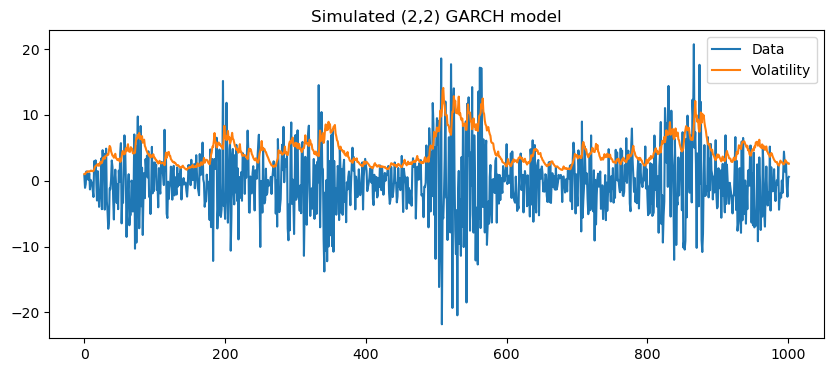

In [30]:
plt.figure(figsize = (10, 4))
plt.plot(series)
plt.plot(volatility)
plt.legend(['Data', 'Volatility'])
plt.title('Simulated (2,2) GARCH model')

**NOTE**
We see that there are periods of high and low volatility, which is a perfect model for GARCH. Since GARCH has AR piece in it, we can look at PACF plot to know what could be a good starting point, it we have to recover the model

**Since we took a square root of the dataset in the equation, and have taken lag 2. A pacf plot with square should show it**

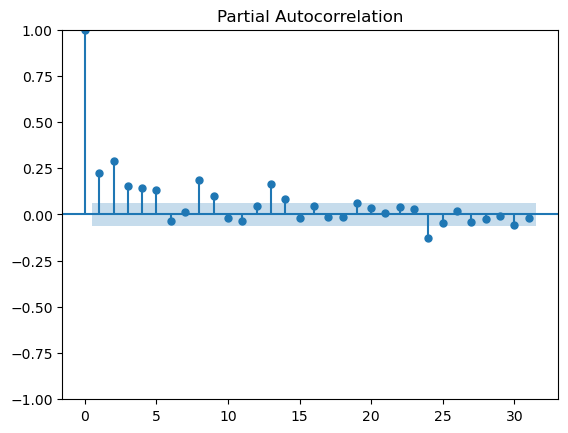

In [31]:
pacf_plot = plot_pacf(np.array(series) **2)
plt.show()

## Fit the GARCH model

In [32]:
train_df, test_df = series[:-test_df_size], series[-test_df_size:]

In [33]:
model = arch_model(train_df, p =2, q =2)
model_fit = model.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 111829.5874424317
Iteration:      2,   Func. Count:     17,   Neg. LLF: 143394.63797238935
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2678.2287257789394
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2522.2398945447876
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2591.7665629868716
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2527.2337496732684
Iteration:      7,   Func. Count:     58,   Neg. LLF: 2522.5065015225437
Iteration:      8,   Func. Count:     66,   Neg. LLF: 2519.964168317424
Iteration:      9,   Func. Count:     73,   Neg. LLF: 2532.030018742582
Iteration:     10,   Func. Count:     83,   Neg. LLF: 2519.958321050054
Iteration:     11,   Func. Count:     90,   Neg. LLF: 2519.9578074034457
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2519.9578074037104
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2519.9578074034457
            Iterati

In [34]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2519.96
Distribution:                  Normal   AIC:                           5051.92
Method:            Maximum Likelihood   BIC:                           5080.74
                                        No. Observations:                  902
Date:                Thu, Aug 08 2024   Df Residuals:                      901
Time:                        08:59:58   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.1829  9.648e-02     -1.896  5.796e-02 [ -0.372,6.168e-03]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.5077      0.195      2.604  9.221e-03    [  0.126,  0.890]
alpha[1]       0.0770  4.453e-02      1.729  8.389e-02 [-1.030e-02,  0.164]
alpha[2]       0.2277  6.498e-02      3.504  4.585e-04    [  0.100,  0.355]
beta[1]        0.3873      0.266      1.456      0.145    [ -0.134,  0.909]
beta[2]        0.3059      0.224      1.363      0.173    [ -0.134,  0.746]
===========================================================================

Covariance estimator: robust
"""

### NOTE 
**From the above summary, we see the value of omega, alpha_1, alpha_2, beta_1, beta_2 are quite close to the values we started with, and all of them have P score less than 0.5, which means they are important (as expected)**

## Predict

In [40]:
predictions = model_fit.forecast(horizon = test_df_size)

Text(0.5, 1.0, 'Volatility prediction')

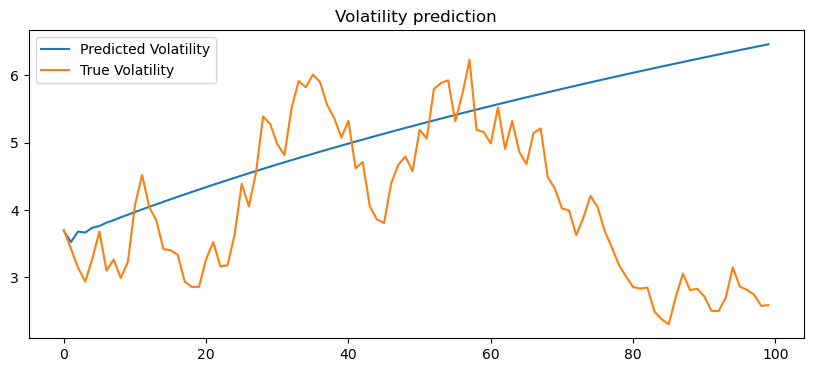

In [63]:
plt.figure(figsize = (10, 4))
plt.plot(np.sqrt(predictions.variance.values[0]))
plt.plot(volatility[-test_df_size:])
plt.legend(['Predicted Volatility', 'True Volatility'])
plt.title('Volatility prediction')

**We seee that for few dataset, the predicted volatility was quite good but then it became bad as we are forecasting a lot in advance**

## Rolling forecast origin

In [76]:
rolling_prediction = []

for i in range(test_df_size):

    train_df = series[: -(test_df_size - i)]
    model = arch_model(train_df, p = 2, q = 2)
    model_fit = model.fit()
    pred = model_fit.forecast(horizon = 1)
    rolling_prediction.append(np.sqrt(pred.variance.values[0][0]))

Iteration:      1,   Func. Count:      8,   Neg. LLF: 111829.5874424317
Iteration:      2,   Func. Count:     17,   Neg. LLF: 143394.63797238935
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2678.2287257789394
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2522.2398945447876
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2591.7665629868716
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2527.2337496732684
Iteration:      7,   Func. Count:     58,   Neg. LLF: 2522.5065015225437
Iteration:      8,   Func. Count:     66,   Neg. LLF: 2519.964168317424
Iteration:      9,   Func. Count:     73,   Neg. LLF: 2532.030018742582
Iteration:     10,   Func. Count:     83,   Neg. LLF: 2519.958321050054
Iteration:     11,   Func. Count:     90,   Neg. LLF: 2519.9578074034457
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2519.9578074037104
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2519.9578074034457
            Iterati

In [96]:
## if doing rolling prediction for 5 days 
rolling_prediction_5days = []

for i in range(0, test_df_size, 5):

    train_df = series[: -(test_df_size - i)]
    model = arch_model(train_df, p = 2, q = 2)
    model_fit = model.fit()
    pred = model_fit.forecast(horizon = 5)
    rolling_prediction_5days.append(np.sqrt(pred.variance.values[0][0]))
    rolling_prediction_5days.append(np.sqrt(pred.variance.values[0][1]))
    rolling_prediction_5days.append(np.sqrt(pred.variance.values[0][2]))
    rolling_prediction_5days.append(np.sqrt(pred.variance.values[0][3]))
    rolling_prediction_5days.append(np.sqrt(pred.variance.values[0][4]))

Iteration:      1,   Func. Count:      8,   Neg. LLF: 111829.5874424317
Iteration:      2,   Func. Count:     17,   Neg. LLF: 143394.63797238935
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2678.2287257789394
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2522.2398945447876
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2591.7665629868716
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2527.2337496732684
Iteration:      7,   Func. Count:     58,   Neg. LLF: 2522.5065015225437
Iteration:      8,   Func. Count:     66,   Neg. LLF: 2519.964168317424
Iteration:      9,   Func. Count:     73,   Neg. LLF: 2532.030018742582
Iteration:     10,   Func. Count:     83,   Neg. LLF: 2519.958321050054
Iteration:     11,   Func. Count:     90,   Neg. LLF: 2519.9578074034457
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2519.9578074037104
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2519.9578074034457
            Iterati

Text(0.5, 1.0, 'Volatility prediction')

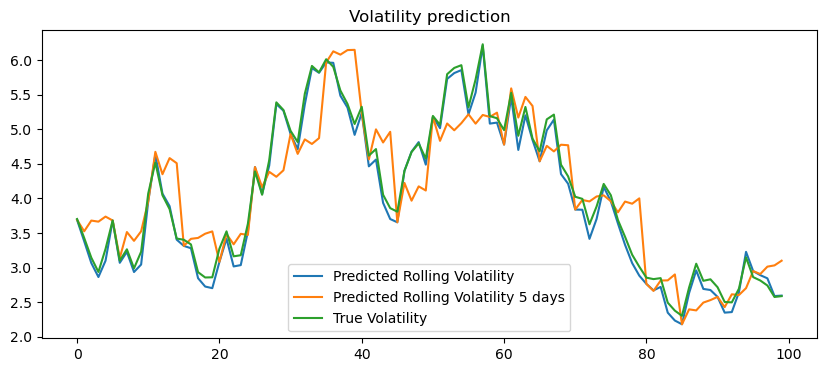

In [97]:
plt.figure(figsize = (10, 4))
plt.plot(rolling_prediction)
plt.plot(rolling_prediction_5days)
plt.plot(volatility[-test_df_size:])
plt.legend(['Predicted Rolling Volatility', 'Predicted Rolling Volatility 5 days', 'True Volatility'])
plt.title('Volatility prediction')

### NOTE:
We see that predicting too much in advance gives bad result